In [ ]:
!pip install timm umap-learn --quiet


In [3]:
import numpy as np
import pandas as pd
import torch
import timm
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.decomposition import PCA

In [4]:
# Load grayscale particles
particles = np.loadtxt("particles.csv", delimiter=',', dtype=np.uint8)
particles = particles.reshape(-1, 64, 64)

# Image preprocessing (224x224, normalized, 3-channel)
transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
def extract_features(particles, model, model_name):
    model.eval().cuda()
    features = []

    with torch.no_grad():
        for img in tqdm(particles, desc=f"Extracting with {model_name}"):
            pil_img = Image.fromarray(img)
            tensor = transform(pil_img).unsqueeze(0).cuda()
            feat = model(tensor).squeeze().cpu().numpy()
            features.append(feat)

    return np.array(features)

In [6]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
features_vit = extract_features(particles, vit, "ViT Base")

Extracting with ViT Base: 100%|██████████| 18252/18252 [03:29<00:00, 87.23it/s]


In [ ]:
def plot_clusters(reduced, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=5)
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_clusters(reduced_vit, labels_vit, "ViT Base Clusters")


In [8]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
reduced = reducer.fit_transform(features_vit)

In [9]:
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(reduced)
sil = silhouette_score(reduced, labels)
db = davies_bouldin_score(reduced, labels)
ch = calinski_harabasz_score(reduced, labels)
print(f"Silhouette Score: {sil:.4f} (higher is better)")
print(f"Davies-Bouldin Index: {db:.4f} (lower is better)")
print(f"Calinski-Harabasz Score: {ch:.4f} (higher is better)")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4309 (higher is better)
Davies-Bouldin Index: 0.8073 (lower is better)
Calinski-Harabasz Score: 29874.8313 (higher is better)


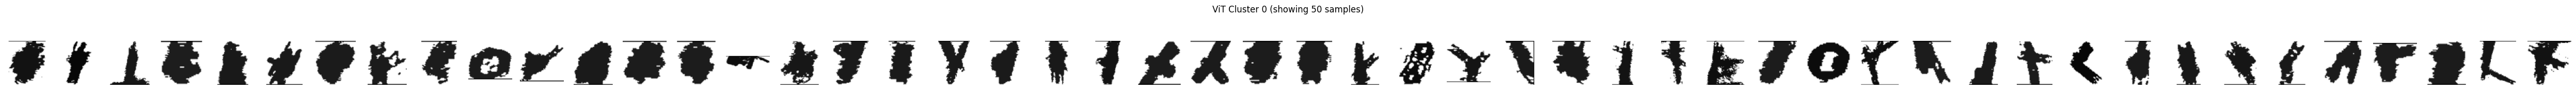

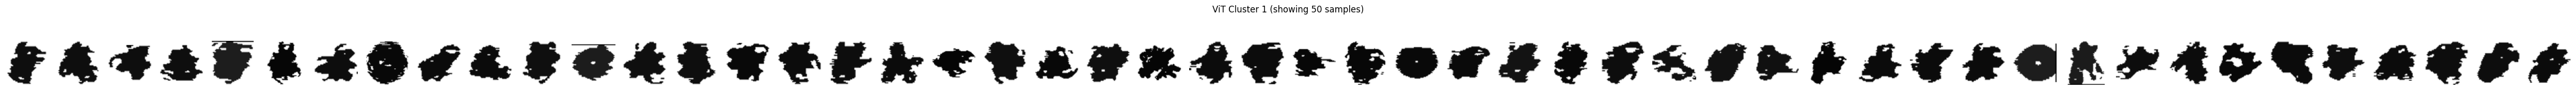

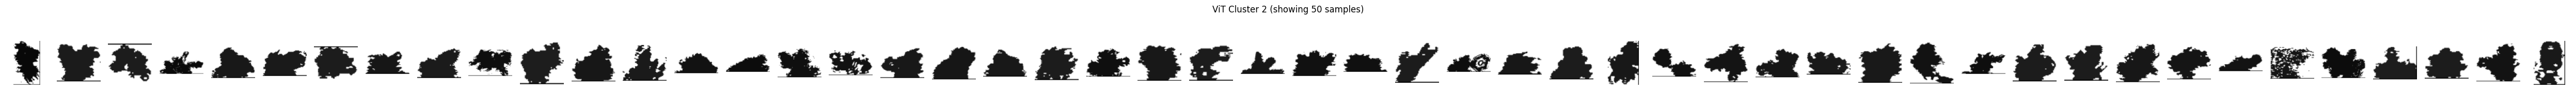

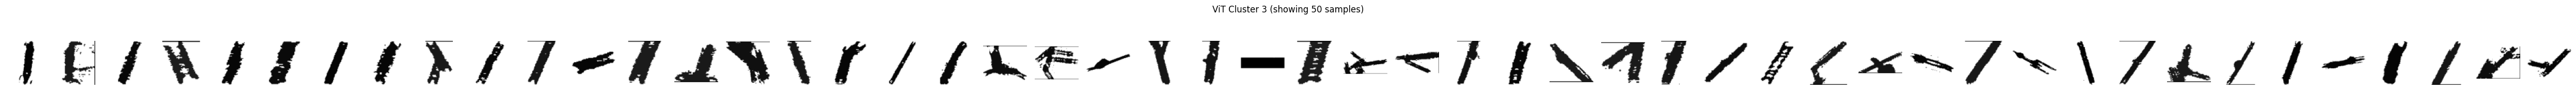

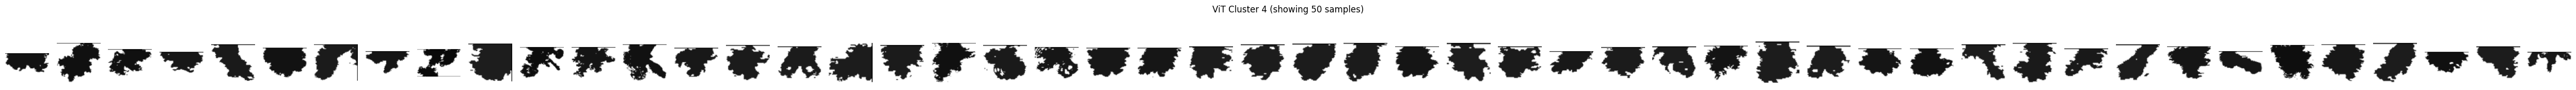

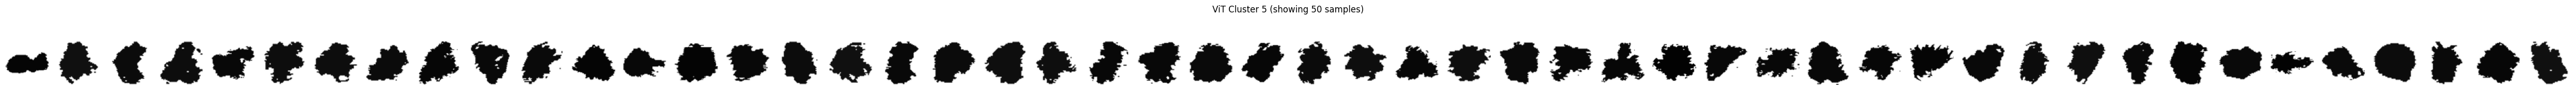

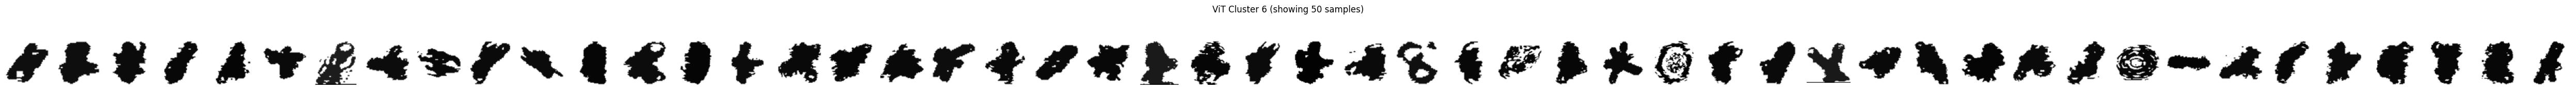

In [15]:
def show_random_particles_per_vit_cluster(particles, labels, n=8):
    unique_clusters = sorted(np.unique(labels))

    for cluster_id in unique_clusters:
        indices = np.where(labels == cluster_id)[0]
        if len(indices) == 0:
            continue

        sample_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)

        plt.figure(figsize=(n, 2))
        for i, idx in enumerate(sample_indices):
            img = particles[idx]
            plt.subplot(1, n, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.suptitle(f"ViT Cluster {cluster_id} (showing {len(sample_indices)} samples)")
        plt.tight_layout()
        plt.show()

# Run the viewer
show_random_particles_per_vit_cluster(particles, labels, n=50)


In [ ]:
df_clusters = pd.DataFrame({
    "particle_id": np.arange(len(labels)),
    "cluster_id": labels
})
df_clusters.to_csv("/kaggle/working/particles_vitbase_umap_kmeans.csv", index=False)
print("✅ Saved CSV: particles_resnet50_umap_kmeans.csv")

In [ ]:
output_root = "/kaggle/working/clustered_particles_vitbase"
os.makedirs(output_root, exist_ok=True)

for cluster_id in np.unique(labels):
    folder = os.path.join(output_root, f"cluster_{cluster_id}")
    os.makedirs(folder, exist_ok=True)
    indices = np.where(labels == cluster_id)[0]
    for idx in indices:
        img = Image.fromarray(particles[idx])
        img.save(os.path.join(folder, f"particle_{idx:05d}.png"))

# Zip for download
zip_path = shutil.make_archive(output_root, 'zip', output_root)
print(f"✅ ZIP ready: {zip_path}")

In [ ]:
torch.save(vit, "vit_base_patch16_224.pth")